In [1]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [2]:
from qnet.algebra.operator_algebra import *
from qnet.algebra.circuit_algebra import *
import qnet.algebra.state_algebra as sa
from qnet.circuit_components.displace_cc import Displace

from qnet.algebra.operator_algebra import get_coeffs ### used later to make time-dependent terms from reduced model.

from qutip import *
from scipy import *

import sympy; sympy.init_printing(use_latex="mathjax")
from sympy import sqrt
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import itertools
from imp import reload
import pickle

## Sometimes Macs will have an issue with Matplotlib, this seems to fix it.
## see http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python

import matplotlib as mil
mil.use('TkAgg')

/Users/gil/anaconda/envs/python_3_env/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import sample_systems

In [4]:
import build_markov
import warnings
warnings.filterwarnings("ignore")

sys.path.append('./make_quantum_jump_trajectories/')
from mcdata2matfile_or_pkl import mcdata2matfile_or_pkl

## save to a folder

import os
directory_name = "/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)

In [5]:
def load(name):
    f = open(name,'rb')
    tmp = pickle.load(f)
    f.close()
    return tmp

def save(thing,name):
    f = open(name,'wb')
    pickle.dump(thing,f)
    f.close()

In [33]:
from scipy.stats import gaussian_kde

## Plot density
def plot_density(x,y,s = 10):
    if len(x) != len(y):
        raise ValueError
    if len(x) > 10000:
        x = x[::len(x)/10000]
        y = y[::len(y)/10000]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig = plt.figure(0,)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )

    ax.scatter(x, y, c=z, s=s, edgecolor='')

In [7]:
def plot_N1_v_N2(mcdata):
    N1,_,_,N2,_,_ = np.concatenate(np.asarray(coherent_2kerr_mcdata.expect), axis = -1)
    plot_density(N1, N2,s = 50)
    plt.xlim(0,14)
    plt.ylim(0,14)

In [8]:
def make_drive_coeffs(x,p,delta_t):
    def drive_coeff_x(t,args):
        step = int(t / delta_t)
        return x[step]
    def drive_coeff_p(t,args):
        step = int(t / delta_t)
        return p[step]
    return drive_coeff_x,drive_coeff_p

In [9]:
def make_driven_model(drive_coeff_x,drive_coeff_p):
    ## Hamiltonian due to drive. multiply by 2 to include effects on L.
    a_k = Destroy('1')
    a_k.space.dimension = Nfock
    S = -identity_matrix(2)
    L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
    H = 0.
    
    driven_slh= (SLH(S, L, H).toSLH()<< Displace(alpha=1)+cid(1)).toSLH() ## set drive = '1'
    drive_operator_x = (driven_slh.H*2).substitute(params).to_qutip()
    
    driven_slh = (SLH(S, L, H).toSLH()<< Displace(alpha=1j)+cid(1)).toSLH() ## set drive = '1j'
    drive_operator_p = (driven_slh.H*2).substitute(params).to_qutip()
    
    ## non driven kerr
    H0, L0 = KERR_lst[0].substitute(params).HL_to_qutip()
    
    H_driven_num = [H0, 
                [drive_operator_x, drive_coeff_x],
                [drive_operator_p, drive_coeff_p]]
    
    return H_driven_num,L0

In [16]:
####
Regime = "kerr_bistable_cascade"

## matlab file.
save_mat = False
## pkl file (can be loaded in python) in the same format as above.
save_pkl = True
file_name = "." + directory_name + '/' + Regime

# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

## bistable regime
if Regime == "kerr_bistable_cascade":
    params = {alpha0 : 47., chi : -106.066, Delta : 750., kappa_1 : 220, kappa_2 : 1e-10,
              'Ntraj' : 1, 'duration' : 100000., 'Nfock' : 15}
else:
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 1e-10, kappa_1 : 0.5, kappa_2 : 1e-10,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}

## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']

Tsim = np.arange(0, duration/1000, 1e-3)
delta_t = Tsim[1] - Tsim[0]

In [17]:
NUM_KERR = 2
# Construct Kerr SLH
a_lst = [Destroy(str(i)) for i in range(NUM_KERR)]

for a in a_lst:
    a.space.dimension = Nfock

S_lst = [-identity_matrix(2)]*NUM_KERR
L_lst = [[sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k] for a_k in a_lst]
H_lst = [Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k for a_k in a_lst]
KERR_lst = [SLH(S, L, H).toSLH() for S,L,H in zip(S_lst,L_lst,H_lst) ]

In [19]:
# driven_slh= (SLH(S, L, H).toSLH()<< Displace(alpha=1)+cid(1)).toSLH() ## set drive = '1'
# drive_operator_x = (driven_slh.H*2).substitute(params).to_qutip()

In [20]:
# driven_slh

In [21]:
KERR_lst[0]

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', '')))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('0', '')))]]), OperatorPlus(ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('0', '')), Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('0', ''))))))

# List of all models considered

Here SLH driven means the SLH rule is used to find the drive.  This gives a term in both the L and the H operators. Coherently driven means that we have used an equivalence on the master equation level to move the extra term on the L operator to the H operator, finding twice the original added term on H.

The text below describes the qutip output for each model. If it is not present it has not been implemented.

## Pure simulations

### coherently driven Kerr
coherent_kerr_mcdata

### SLH driven Kerr

### coherently driven 2 Kerrs
coherent_2kerr_mcdata

### SLH driven 2 Kerrs
__________________________


## Semiclassical simulations

### coherently driven kerr semiclassically feeding into a second kerr
semi_2kerr_mcdata_lst 

### SLH driven kerr semiclassically feeding into a second kerr

__________________________

## HMM models

### Red(coherently driven Kerr)

markov_coherent_kerr

### Red_{12} (coherently driven 2 Kerrs) -- HMM using operators from both Kerrs
markov_coherent_2kerr

### Red_{2} (coherently driven 2 Kerrs) -- HMM using operators from the second Kerr only
markov_coherent_2kerr2

### Red(coherently driven Kerr) feeding semiclassically into second Kerr
semi_red_mcdata

### Red(  Red(coherently driven Kerr) feeding semiclassically into second Kerr ) 
markov_semi_to_kerr

# Coherently Driven Kerr

In [23]:
## Observables
a = a_lst[0]

In [92]:
single_psi0 = qutip.tensor(qutip.basis(Nfock, 0))
driven_kerr = (KERR_lst[0] << Displace(alpha=2*alpha0)+cid(1)).toSLH()
single_kerr_obs = tuple([a.dag()*a, a+a.dag(), (a-a.dag())/1j])
single_kerr_obsq = [o.to_qutip(full_space=driven_kerr.space) for o in single_kerr_obs]

In [93]:
H_num_0, L_num_0 = KERR_lst[0].substitute(params).HL_to_qutip()  ## Undriven
H_num, L_num = driven_kerr.substitute(params).HL_to_qutip()      ## Driven with 2 alpha0

In [94]:
## generate trajectory
coherent_kerr_mcdata = qutip.mcsolve(H_num, single_psi0, Tsim[:10000], L_num_0, 
                       single_kerr_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=True,average_expect=False,seeds = [1],))

100.0%. Run time:  26.90s. Est. time left: 00:00:00:00
Total run time:  27.01s


In [95]:
save(coherent_kerr_mcdata,'coherent_kerr_mcdata')

In [96]:
coherent_kerr_mcdata = load('coherent_kerr_mcdata')

# SLH Driven Kerr

In [97]:
SLH_kerr = (KERR_lst[0] << Displace(alpha=alpha0)+cid(1)).toSLH()

In [98]:
SLH_kerr.L

Matrix([[OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', ''))))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('0', '')))]])

In [99]:
SLH_kerr.H

OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(alpha_0*sqrt(kappa_1), Create(LocalSpace('0', ''))), ScalarTimesOperator(-sqrt(kappa_1)*conjugate(alpha_0), Destroy(LocalSpace('0', ''))))), ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('0', '')), Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))))

In [100]:
H_num, L_num  = SLH_kerr.substitute(params).HL_to_qutip()

In [101]:
## generate trajectory
SLH_kerr_mcdata = qutip.mcsolve(H_num, single_psi0, Tsim[:10000], L_num, 
                       single_kerr_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=True,average_expect=False,seeds = [1],))

100.0%. Run time:  32.56s. Est. time left: 00:00:00:00
Total run time:  32.76s


In [102]:
N1s_co,x1s_co,p1s_co  = np.split(np.asarray(coherent_kerr_mcdata.expect),3,axis=1)

In [103]:
N1s_slh,x1s_slh,p1s_slh  = np.split(np.asarray(SLH_kerr_mcdata.expect),3,axis=1)

In [104]:
N1_co = np.concatenate(np.concatenate(N1s_co))
N1_slh = np.concatenate(np.concatenate(N1s_slh))

(0, 14)

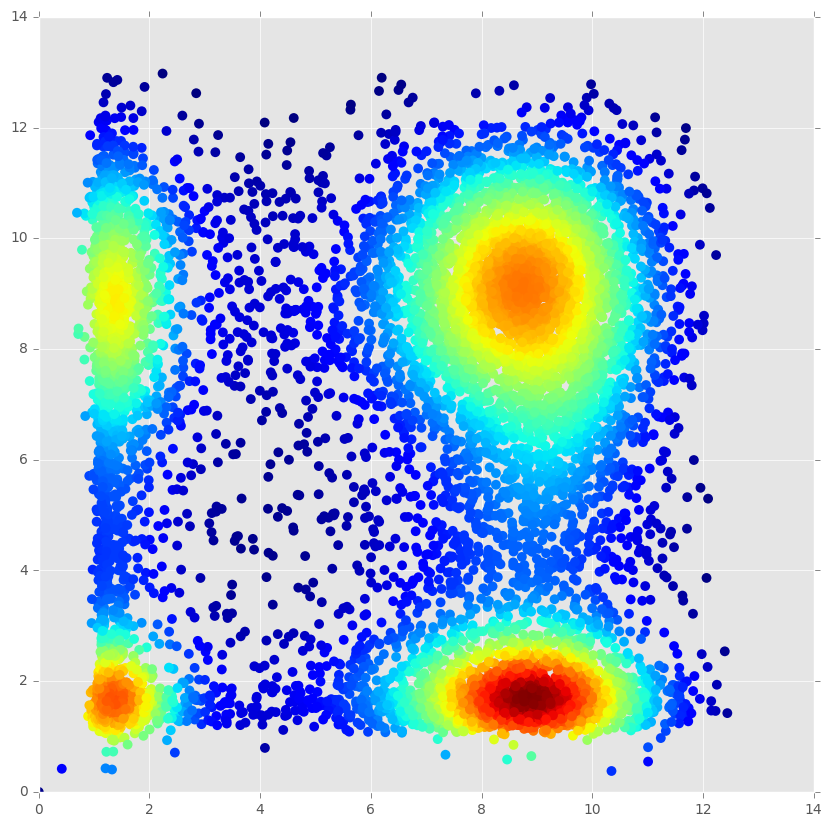

In [105]:
plot_density(N1_co,N1_slh,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

In [90]:
save(SLH_kerr_mcdata,'SLH_kerr_mcdata')

In [91]:
SLH_kerr_mcdata = load('SLH_kerr_mcdata')

# coherently driven 2 Kerrs

In [27]:
double_psi0 = qutip.tensor(*[qutip.basis(Nfock, 0)]*2)
undriven_double_kerr = (KERR_lst[1]  << KERR_lst[0]).toSLH()
driven_double_kerr = (KERR_lst[1]  << KERR_lst[0] << Displace(alpha=2*alpha0)+cid(1)).toSLH()

In [28]:
driven_double_kerr.L

Matrix([[OperatorPlus(ScalarTimesOperator(2*alpha_0, IdentityOperator), ScalarTimesOperator(-sqrt(kappa_1), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-sqrt(kappa_2), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('1', ''))))]])

In [29]:
## We can use 
H_num_0_2, L_num_0_2 = undriven_double_kerr.substitute(params).HL_to_qutip()  ## Undriven
H_num_2, L_num_2 = driven_double_kerr.substitute(params).HL_to_qutip()                         ## Driven with 2 alpha0

In [31]:
double_obs = tuple(itertools.chain.from_iterable([[a.dag()*a, a+a.dag(), (a-a.dag())/1j ]  
           for a in a_lst]))
    
double_obsq = [o.to_qutip(full_space=driven_double_kerr.space) for o in double_obs]

In [399]:
coherent_2kerr_mcdata  = qutip.mcsolve(H_num_2, double_psi0, Tsim, L_num_0_2, 
                       double_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=True,average_expect=False,seeds = [1],))

100.0%. Run time: 703.88s. Est. time left: 00:00:00:00
Total run time: 704.23s


In [410]:
save(coherent_2kerr_mcdata,'coherent_2kerr_mcdata')

In [35]:
coherent_2kerr_mcdata = load('coherent_2kerr_mcdata')

In [36]:
N1s,x1s,p1s,N2s,x2s,p2s  = np.split(np.asarray(coherent_2kerr_mcdata.expect),6,axis=1)

In [37]:
N1 = np.concatenate(np.concatenate(N1s))
N2 = np.concatenate(np.concatenate(N2s))

(0, 14)

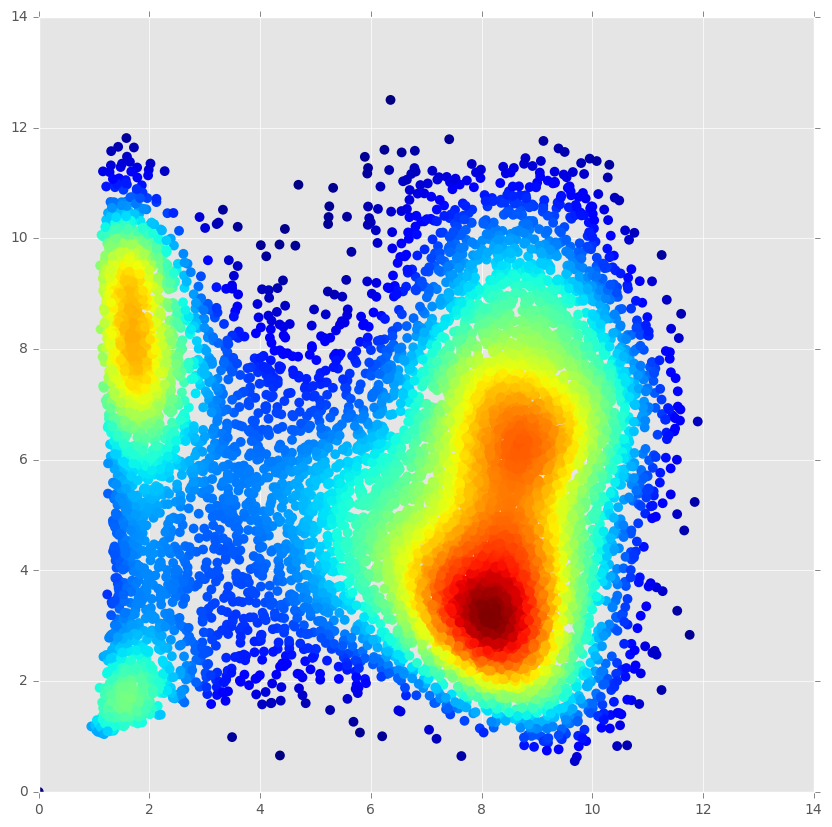

In [38]:
plot_density(N1, N2,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

# coherently driven kerr semiclassically feeding into a second kerr

In [39]:
Ns,xs,ps  = np.split(np.asarray(coherent_kerr_mcdata.expect),3,axis=1)

In [405]:
semi_2kerr_H_lst = []
semi_2kerr_mcdata_lst = []

for traj_num in range(Ntraj):
    ## divide x and p by 2 since a = (x + pi) / 2.
    ## multiply x and p by 2 since we are using only the L term (not H)
    drive_coeff_x,drive_coeff_p = make_drive_coeffs(xs[traj_num][0]/2 + params[alpha0],ps[traj_num][0]/2,delta_t)
    H_driven_num,L0 = make_driven_model(drive_coeff_x,drive_coeff_p)
    semi_2kerr_H_lst.append(H_driven_num)
    
    semi_2kerr_mcdata_lst.append(qutip.mcsolve(H_driven_num, single_psi0, Tsim,  L0,
                                   single_kerr_obsq, ntraj=1,
                                   options=qutip.Odeoptions(store_states=True,average_expect=False,rhs_reuse=True,
                                   seeds = [traj_num])))

100.0%. Run time: 1134.17s. Est. time left: 00:00:00:00
Total run time: 1134.43s


In [421]:
save(semi_2kerr_mcdata_lst,'semi_2kerr_mcdata_lst')

In [40]:
semi_2kerr_mcdata_lst = load('semi_2kerr_mcdata_lst')

In [41]:
N2s,x2s,p2s = np.concatenate(
    np.asarray(
        [np.asarray(semi_2kerr_mcdata_lst[i].expect)[0] 
             for i in range(Ntraj)]),axis = -1)

In [42]:
N1s = np.concatenate(Ns,axis = -1)[0]

(0, 14)

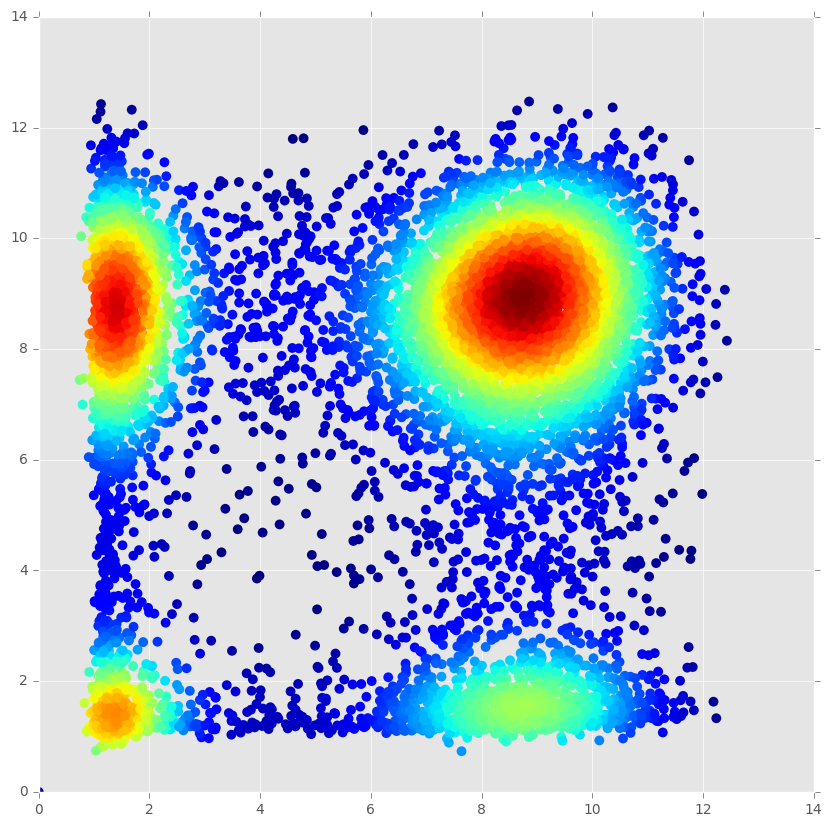

In [43]:
plot_density(N1s, N2s,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

 # Red(coherently driven Kerr)

In [121]:
dim_red_coherent_kerr = build_markov.dim_red_builder(Regime= "coherent_kerr",
                                        num_sample_points = 10000,
                                        sample_type = 'last_n',
                                        mcdata = coherent_kerr_mcdata,
                                       )

In [122]:
markov_coherent_kerr = build_markov.markov_model_builder(dim_red_coherent_kerr)

In [123]:
markov_coherent_kerr.load()

In [ ]:
markov_coherent_kerr.build_model(n_clusters = 15,which_coords = 'expects')

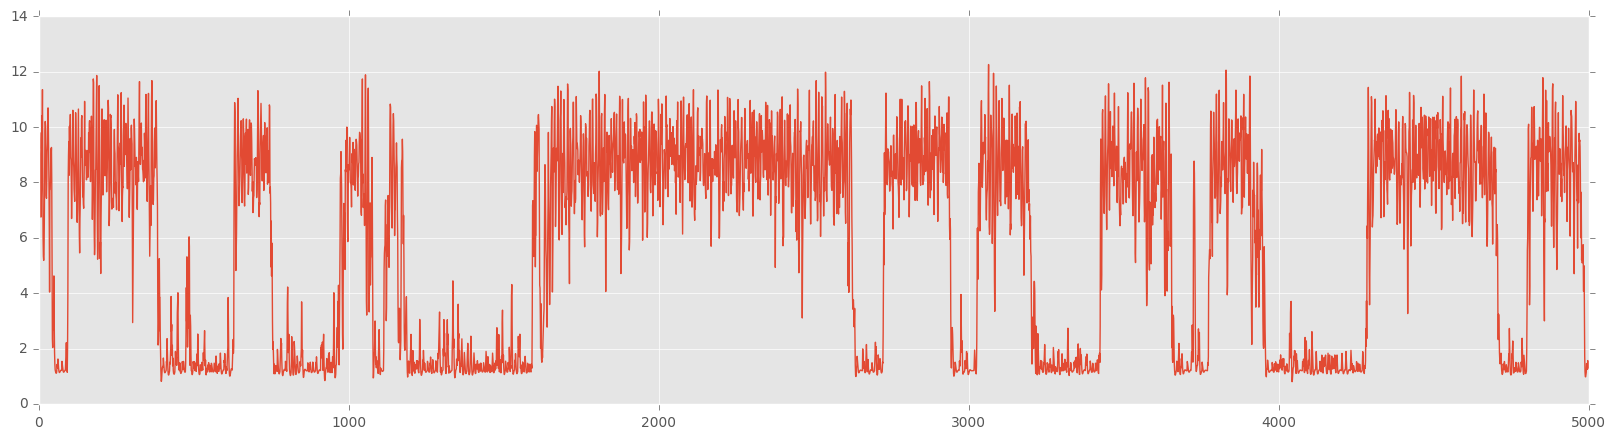

In [466]:
X,Z = markov_coherent_kerr.hmm_model.sample(5000)
N,x,p = X.T

plt.figure(figsize=(20,5))
plt.plot(np.asarray(coherent_kerr_mcdata.expect)[0,0,:][10000:15000])

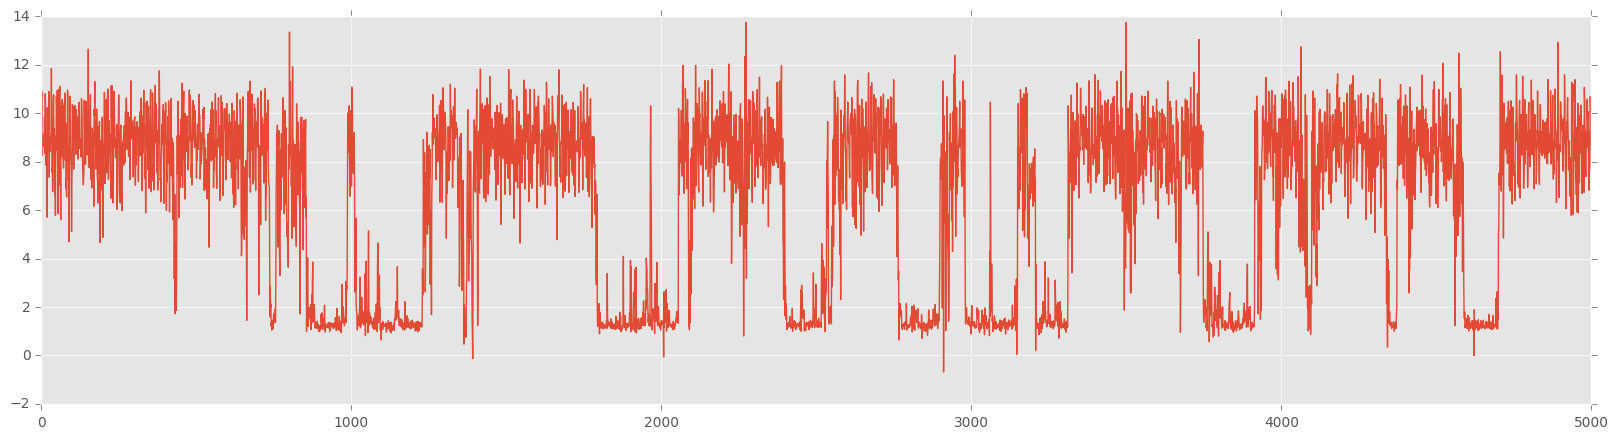

In [467]:
plt.figure(figsize=(20,5))
plt.plot(N)

In [439]:
markov_coherent_kerr.save()

# Red_{12} (coherently driven 2 Kerrs) -- HMM using operators from both Kerrs

In [108]:
dim_red_coherent_2kerr = build_markov.dim_red_builder(Regime= "coherent_2kerr",
                                                  num_sample_points = 20000,
                                        sample_type = 'last_n',
                                        mcdata = coherent_2kerr_mcdata,
                                       )

In [110]:
markov_coherent_2kerr = build_markov.markov_model_builder(dim_red_coherent_2kerr)

In [111]:
markov_coherent_2kerr.load()

In [ ]:
markov_coherent_2kerr.build_model(n_clusters = 15,which_coords = 'expects')

In [112]:
X,Z = markov_coherent_2kerr.hmm_model.sample(100000)
N1,x1,p1,N2,x2,p2 = X.T

(0, 14)

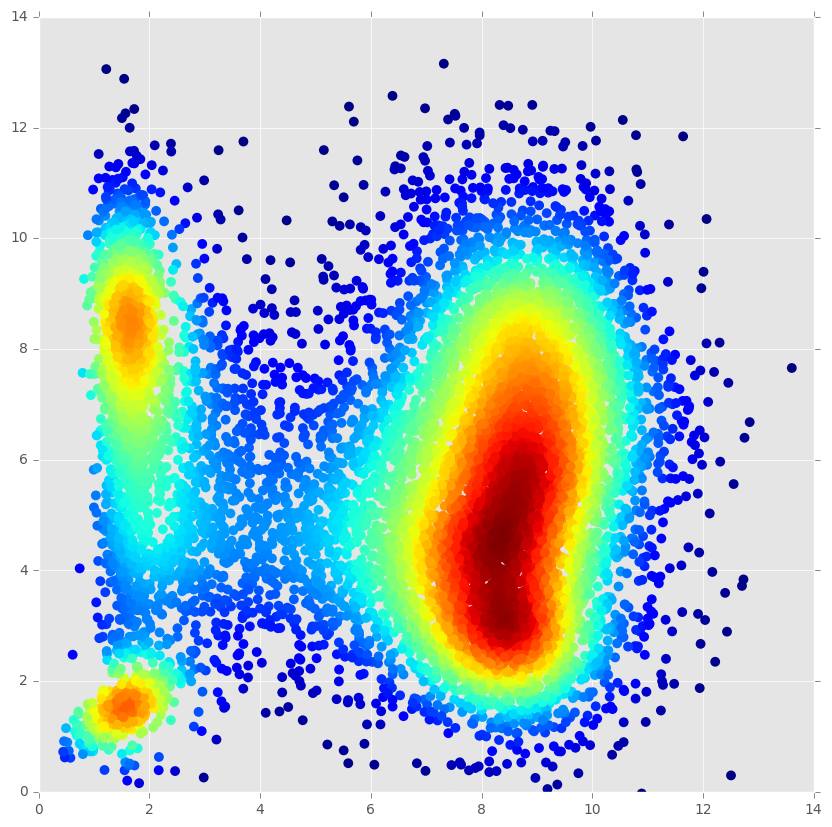

In [113]:
plot_density(N1, N2,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

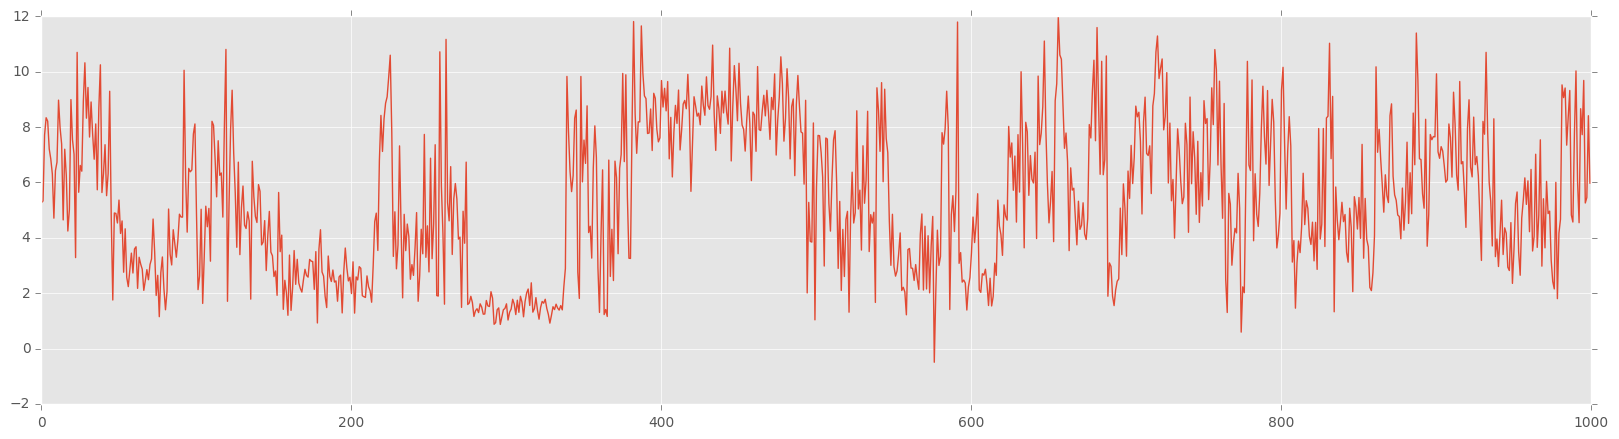

In [502]:
plt.figure(figsize=(20,5))
plt.plot(N2[:1000])

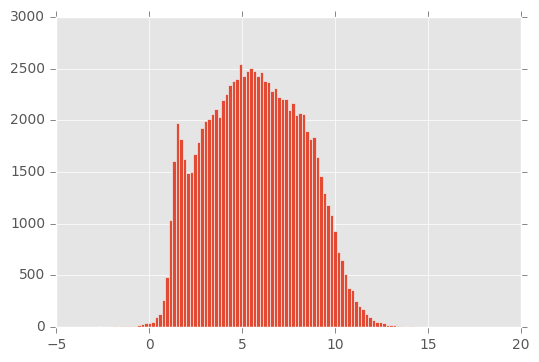

In [503]:
plt.hist(N2,bins=100);

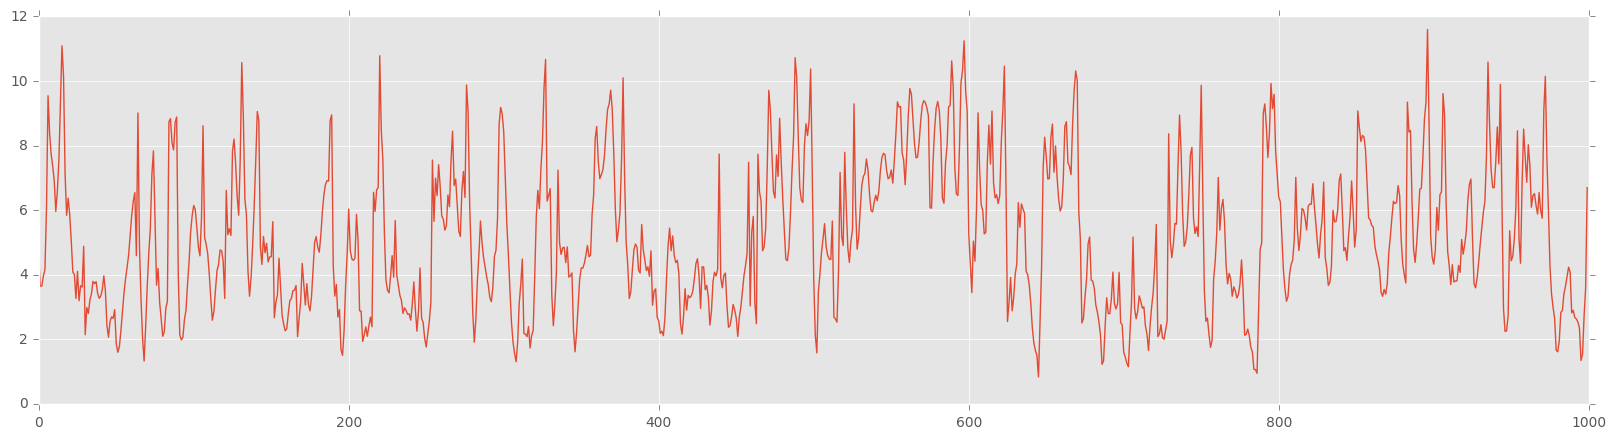

In [494]:
plt.figure(figsize=(20,5))
plt.plot(np.asarray(coherent_2kerr_mcdata.expect)[0,3,:][10000:11000])

In [470]:
markov_coherent_2kerr.save()

#  Red_{2} (coherently driven 2 Kerrs) -- HMM using operators from the second Kerr only

In [114]:
dim_red_coherent_2kerr2 = build_markov.dim_red_builder(Regime= "coherent_2kerr2",
                                         num_sample_points = 20000,
                                        sample_type = 'last_n',
                                        mcdata = coherent_2kerr_mcdata,
                                       )

In [115]:
markov_coherent_2kerr2 = build_markov.markov_model_builder(dim_red_coherent_2kerr2)

In [116]:
markov_coherent_2kerr2.load()

In [ ]:
markov_coherent_2kerr2.build_model(n_clusters = 15,which_coords = 'expects',coords_indices_to_use = [3,4,5])

In [117]:
X,Z = markov_coherent_2kerr2.hmm_model.sample(100000)
N2,x2,p2 = X.T

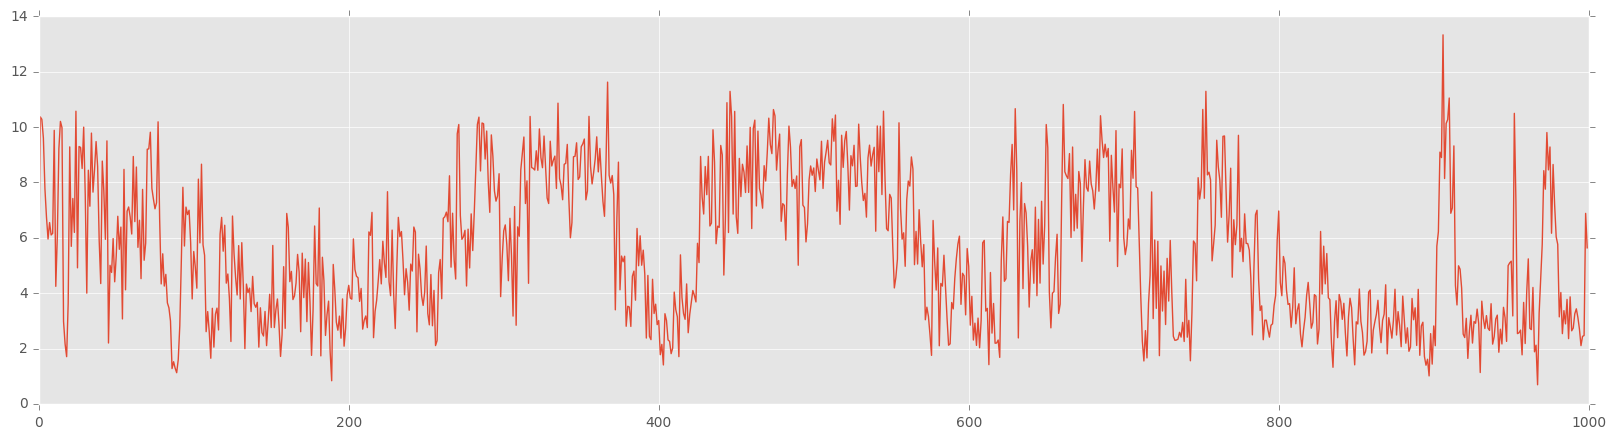

In [118]:
plt.figure(figsize=(20,5))
plt.plot(N2[:1000])

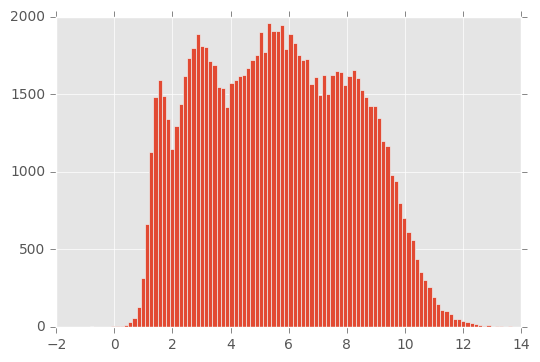

In [119]:
plt.hist(N2,bins=100);

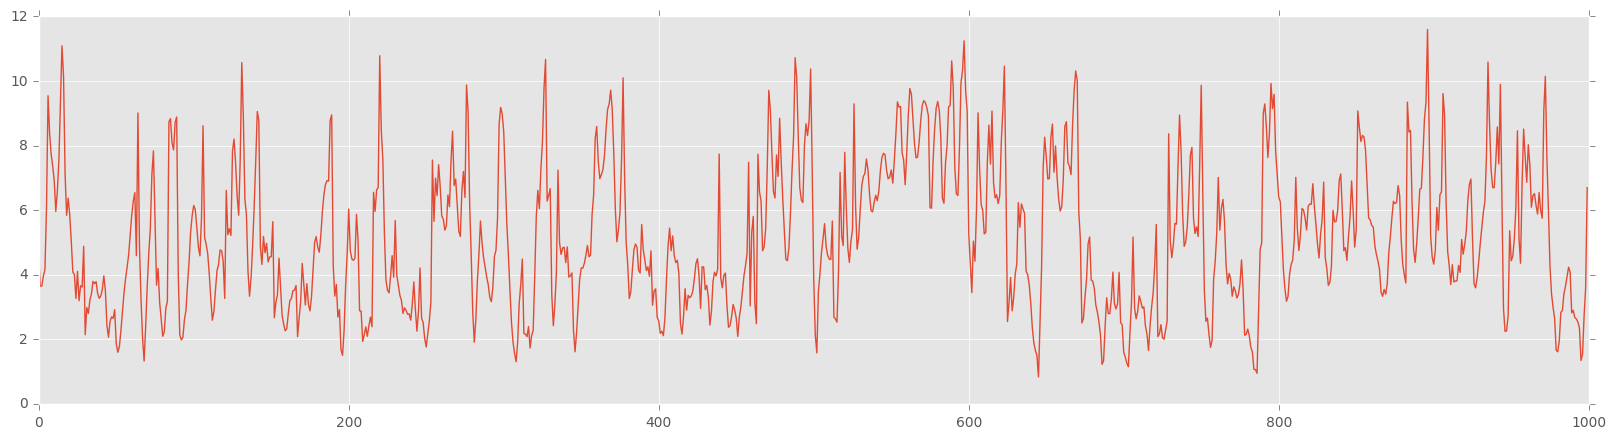

In [498]:
plt.figure(figsize=(20,5))
plt.plot(np.asarray(coherent_2kerr_mcdata.expect)[0,3,:][10000:11000])

In [499]:
markov_coherent_2kerr2.save()

# Red(coherently driven Kerr) feeding semiclassically into second Kerr

In [144]:
## Important: The semi_red_mcdata_lst below should must be consistent with the N,x,p below 
## in order to properly train the next model i.e. Red(Red(kerr) --(semiclassical)-> Kerr)

X,Z = markov_coherent_kerr.hmm_model.sample(20000)
N,x,p = X.T

# save([N,x,p],'coherent_kerr_generated')

semi_red_H = []
semi_red_mcdata_lst = []

## divide x and p by 2 since a = (x + pi) / 2.
## multiply x and p by 2 since we are using only the L term (not H)
drive_coeff_x,drive_coeff_p = make_drive_coeffs(x/2 + params[alpha0],p/2,delta_t)
H_driven_num,L0 = make_driven_model(drive_coeff_x,drive_coeff_p)
semi_red_H.append(H_driven_num)


semi_red_mcdata_lst.append(qutip.mcsolve(H_driven_num, single_psi0, Tsim[:20000],  L0,
                               single_kerr_obsq, ntraj=1,
                               options=qutip.Odeoptions(store_states=True,average_expect=False,rhs_reuse=True,
                               seeds = [1])))

100.0%. Run time: 221.62s. Est. time left: 00:00:00:00
Total run time: 221.84s


In [145]:
# save(semi_red_mcdata_lst,'semi_red_mcdata_lst')

In [146]:
semi_red_mcdata_lst = load('semi_red_mcdata_lst')

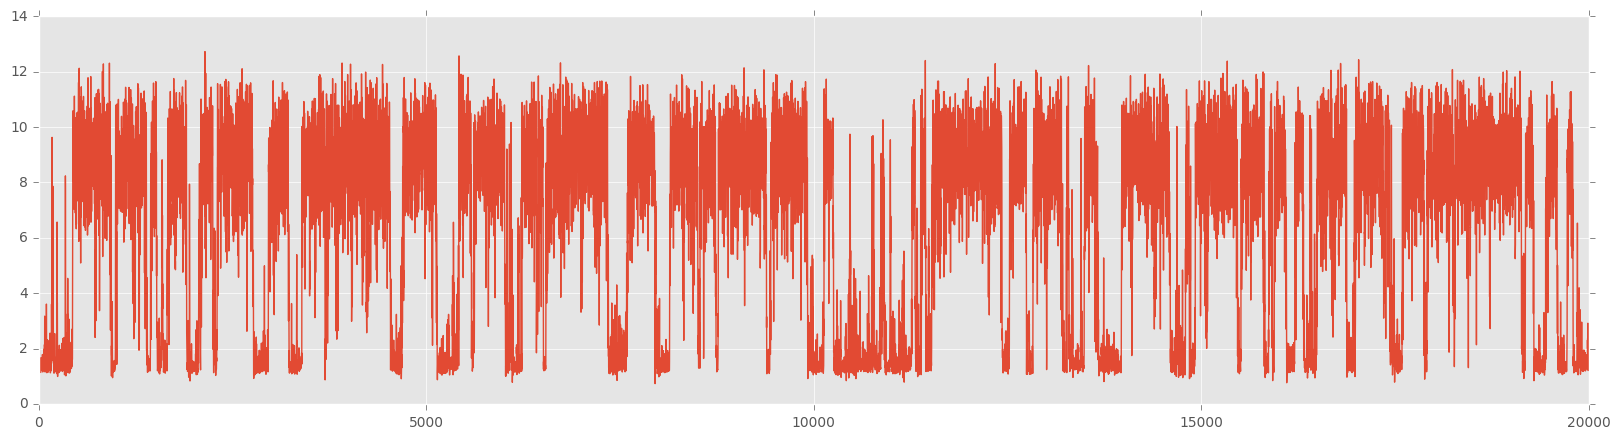

In [147]:
## First coordinate of second model is N2
plt.figure(figsize=(20,5))
plt.plot(np.asarray(semi_red_mcdata_lst[0].expect)[0,0,:]);

# Red(  Red(coherently driven Kerr) feeding semiclassically into second Kerr ) 


In [161]:
dim_red_semi_to_kerr = build_markov.dim_red_builder(Regime= "semi_to_kerr",
                                      num_sample_points = 20000,
                                        sample_type = 'last_n',
                                        mcdata = semi_red_mcdata_lst,
                                       )

In [162]:
markov_semi_to_kerr = build_markov.markov_model_builder(dim_red_semi_to_kerr)

In [163]:
markov_semi_to_kerr.expects_sampled = np.concatenate([
    markov_semi_to_kerr.expects_sampled,np.asarray([N,x,p]).T],axis=-1)

In [130]:
markov_semi_to_kerr.load()

In [164]:
markov_semi_to_kerr.build_model(n_clusters = 15,which_coords = 'expects')

converged True


In [165]:
X,Z = markov_semi_to_kerr.hmm_model.sample(100000)
N1,x1,p1,N2,x2,p2 = X.T

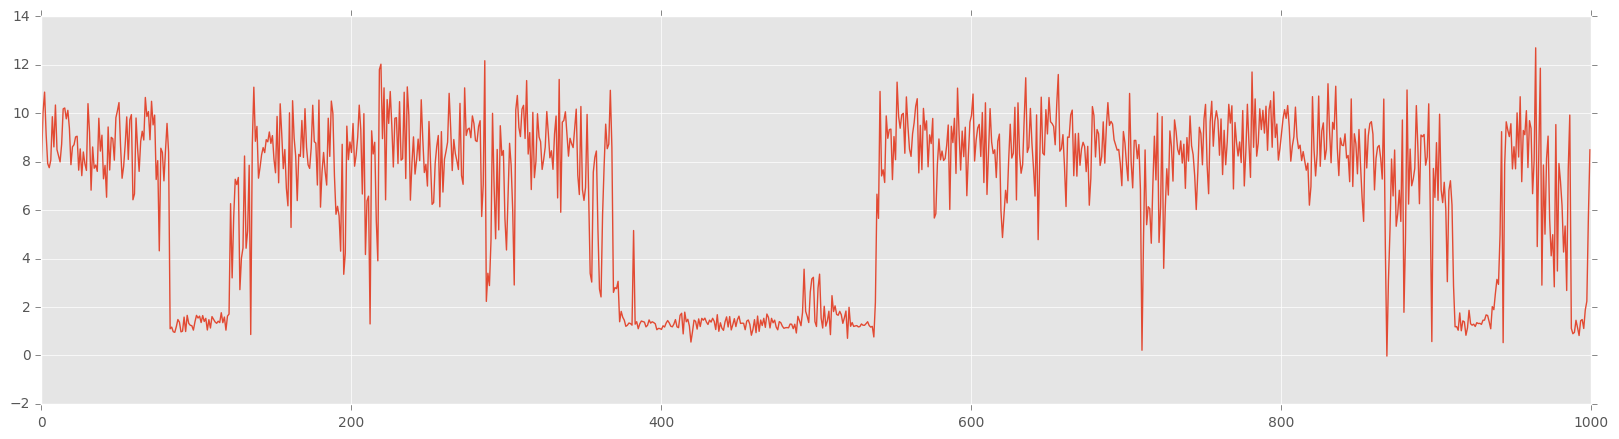

In [166]:
plt.figure(figsize=(20,5))
plt.plot(N2[:1000])

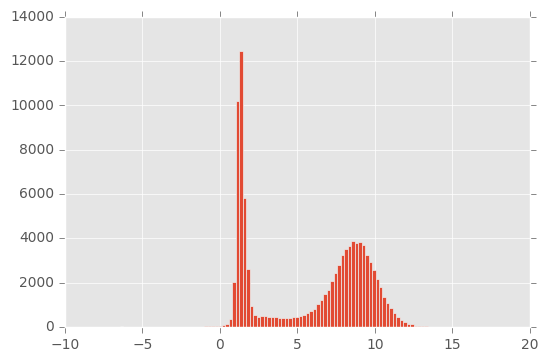

In [167]:
plt.hist(N2,bins=100);

In [168]:
markov_semi_to_kerr.save()

(0, 14)

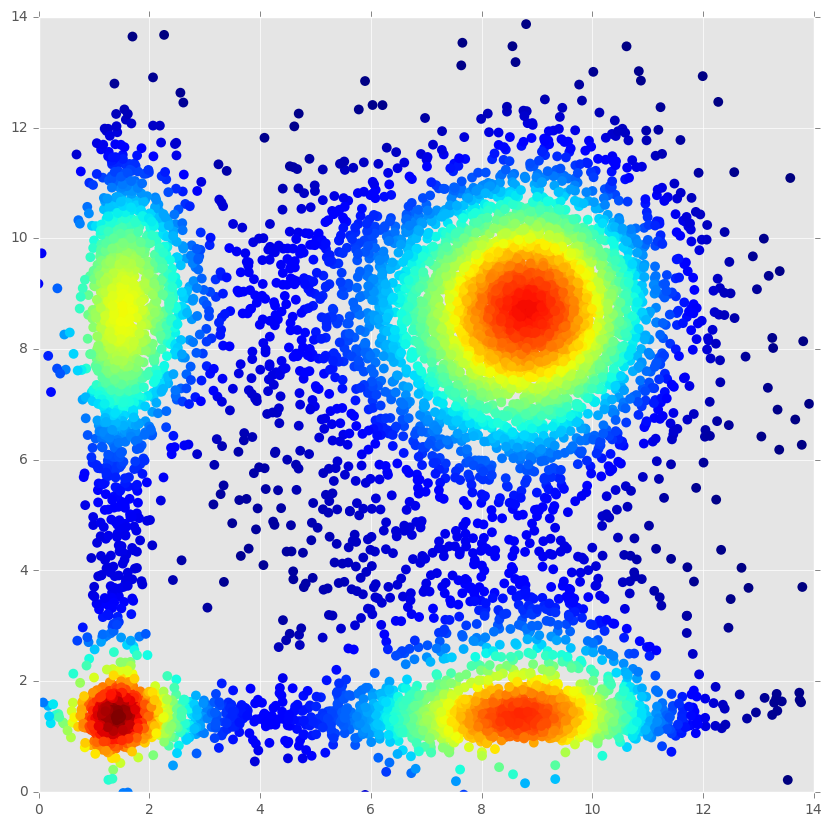

In [169]:
plot_density(N1, N2,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)